In [61]:
import sympy
from sympy import init_printing
from sympy import MutableDenseMatrix
init_printing()

# Use IPython's Latex capabilities to avoid a bug in Sympy's matrix printing
from IPython.display import display, Math, Latex

import numpy as np
import pyamg
from scipy import sparse
from scipy import ndimage
from geoblend.coefficient_matrix import create_coefficient_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['image.interpolation'] = 'none'
mpl.rcParams['image.cmap'] = 'cubehelix'

%matplotlib inline

np.set_printoptions(linewidth=200)

In [2]:
def display_matrix(m):
    """
    Helper function to display the coefficient
    matrix.
    """
    
    if type(m) == MutableDenseMatrix:
        tex = sympy.latex(m)
    elif type(m) == np.ndarray:
        tex = sympy.latex(sympy.Matrix(mask.astype(np.int8).tolist()))
    else:
        # Crazy-ness to get integer represention ...
        tex = sympy.latex(sympy.Matrix(m.toarray().astype(np.int8).tolist()))
    
    display(Math(tex))

In [3]:
def create_auxiliary_equation(mask):
    """
    Create a sympy representation of the auxiliary equation corresponding
    to the Poisson equation.
    
    This prevents me from tedious, error-proned, hand-written algebra.
    """
    
    height, width = mask.shape
    x_domain = range(width)
    y_domain = range(height)
    
    # Create symbolic variables representing the unknown image
    # and the known gradient that will be imposed on the unknown image.
    
    # Note: One variable per pixel. f and g are pixel-aligned.
    f = [ sympy.symbols(' '.join([ 'f%d%d' % (i, j) for j in y_domain ])) for i in x_domain ]
    g = [ sympy.symbols(' '.join([ 'g%d%d' % (i, j) for j in y_domain ])) for i in x_domain ]
    c = [ sympy.symbols(' '.join([ 'c%d%d' % (i, j) for j in y_domain ])) for i in x_domain ]
    
    # Create the variable that will comprise the auxiliary equation.
    equation = 0
    
    for j in y_domain:
        for i in x_domain:
            
            if mask[j][i] == 0:
                continue
            
            #
            # Define the index of the 4-connected neighbors
            #
            
            # For a pixel p with indices (i, j), the
            # 4-connected neighbors are defined by the
            # surrounding 3x3 pixel grid as:
            #
            # - N - 
            # W p E
            # - S - 
            
            nj, ni = j - 1, i
            sj, si = j + 1, i
            ej, ei = j, i + 1
            wj, wi = j, i - 1
            
            # TODO: This pays no attention to boundaries. The gradient
            #       at the boundary should never be sampled.
            if nj in y_domain:
                equation += (f[i][j] - f[ni][nj] - g[i][j]) ** 2
            if ei in x_domain:
                equation += (f[i][j] - f[ei][ej] - g[i][j]) ** 2
            if sj in y_domain:
                equation += (f[i][j] - f[si][sj] - g[i][j]) ** 2
            if wi in x_domain:
                equation += (f[i][j] - f[wi][wj] - g[i][j]) ** 2
    
    return equation, f, g, c

In [5]:
mask1 = np.array([
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  1,  1,  1,  1,  1,  1,  1,  0],
    [ 0,  1,  1,  1,  1,  1,  1,  1,  0],
    [ 0,  1,  1,  1,  1,  1,  1,  1,  0],
    [ 0,  1,  1,  1,  1,  1,  1,  1,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0]
])
mask1

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [6]:
mask2 = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]
])
mask2

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [7]:
eq1, f1, g1, c1 = create_auxiliary_equation(mask1)
eq2, f2, g2, c2 = create_auxiliary_equation(mask2)

In [8]:
eq1

In [9]:
eq2

In [14]:
def linearize_system(mask, equation, f):
    
    indices = np.nonzero(mask)
    return [
        sympy.diff(equation, f[idx[1]][idx[0]])
        for idx in zip(*indices)
    ]

In [17]:
system1 = linearize_system(mask1, eq1, f1)

In [18]:
system2 = linearize_system(mask2, eq2, f2)

In [19]:
mat1 = sympy.Matrix(system1)
mat2 = sympy.Matrix(system2)

In [20]:
def get_unknown_vector(mask, f):
    
    indices = np.nonzero(mask)
    return [
        f[idx[1]][idx[0]]
        for idx in zip(*indices)
    ]

In [21]:
vec1 = get_unknown_vector(mask1, f1)
vec2 = get_unknown_vector(mask2, f2)

In [22]:
vec1

In [23]:
vec2

In [25]:
coeff1 = mat1.jacobian(vec1)
coeff2 = mat2.jacobian(vec2)

In [26]:
display_matrix(coeff1)

<IPython.core.display.Math object>

In [27]:
display_matrix(coeff2)

<IPython.core.display.Math object>

### Sample data

In [31]:
source = np.array([
    [459, 516, 579, 595, 622, 575, 564, 607, 627],
    [451, 509, 540, 561, 528, 515, 537, 621, 614],
    [489, 537, 574, 587, 497, 484, 491, 540, 532],
    [543, 683, 650, 620, 546, 513, 521, 522, 549],
    [557, 656, 666, 628, 576, 570, 571, 545, 546],
    [623, 742, 683, 610, 616, 566, 558, 516, 501]
], dtype=np.uint16)

reference = np.array([
    [555, 555, 514, 514, 514, 514, 479, 479, 479],
    [555, 555, 514, 514, 514, 514, 479, 479, 479],
    [555, 555, 514, 514, 514, 514, 479, 479, 479],
    [504, 504, 472, 472, 472, 472, 458, 458, 458],
    [504, 504, 472, 472, 472, 472, 458, 458, 458],
    [504, 504, 472, 472, 472, 472, 458, 458, 458]
], dtype=np.uint16)

field = np.array([
    [869,  517,  665,  618,  790,  599,  537,  616, 1287],
    [347,   -8,  -63,   -6,  -83,  -64,  -43,  186,  676],
    [425, -107,  -18,   96, -157,  -80, -118,   -6,  425],
    [443,  346,   57,   69,  -22,  -69,  -13,  -67,  596],
    [406,  -24,   47,   40,  -56,   54,   90,   25,  589],
    [1193, 1006,  714,  513,  712,  520,  579,  460,  942]
], dtype=np.int32)

In [33]:
def get_boundary_mask(mask):

    selem = np.array([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ])
    b = ndimage.convolve(mask, selem, mode='constant', cval=0)
    b[b < 0] = 0
    return b

In [34]:
get_boundary_mask(mask1)

array([[0, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 0]])

In [35]:
get_boundary_mask(mask2)

array([[0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 2, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 2, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 2, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0]])

In [39]:
def get_replacements(mask, f, g, reference, field):
    
    # Replace boundaries with values from the reference image
    boundary = get_boundary_mask(mask)
    bindices = np.nonzero(boundary)
    
    boundary_replacements = [
        (f[idx[1]][idx[0]], reference[idx])
        for idx in zip(*bindices)
    ]
    
    indices = np.nonzero(mask)
    
    field_replacements = [
        (g[idx[1]][idx[0]], field[idx])
        for idx in zip(*indices)
    ]
    
    return boundary_replacements + field_replacements

In [41]:
replacements1 = get_replacements(mask1, f1, g1, reference, field)
replacements2 = get_replacements(mask2, f2, g2, reference, field)

In [43]:
display_matrix(mat1.subs(replacements1))

<IPython.core.display.Math object>

In [44]:
display_matrix(mat2.subs(replacements2))

<IPython.core.display.Math object>

In [48]:
x1 = sympy.solve(mat1.subs(replacements1))
x2 = sympy.solve(mat2.subs(replacements2))

In [55]:
x1.keys()

In [57]:
x1[f1[5][1]]

In [58]:
def apply_blended_pixels(x, reference, f):
    img = np.copy(reference)
    
    height, width = reference.shape
    
    for j in range(height):
        for i in range(width):
            if x.has_key(f[i][j]):
                img[j][i] = x[f[i][j]]
    
    return img

In [65]:
img1 = apply_blended_pixels(x1, reference, f1)
img2 = apply_blended_pixels(x2, reference, f2)

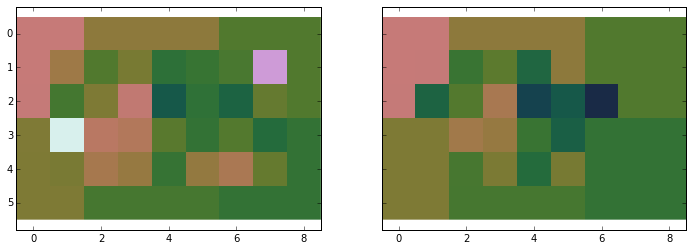

In [69]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
ax1.imshow(img1, vmin=300, vmax=750)
ax2.imshow(img2, vmin=300, vmax=750)

In [70]:
print img1

[[555 555 514 514 514 514 479 479 479]
 [555 524 479 501 452 460 474 613 479]
 [555 470 505 552 418 453 433 491 479]
 [504 713 544 538 483 457 481 444 458]
 [504 501 530 518 459 517 533 491 458]
 [504 504 472 472 472 472 458 458 458]]


In [71]:
print img2

[[555 555 514 514 514 514 479 479 479]
 [555 555 462 486 437 514 479 479 479]
 [555 433 481 532 395 418 372 479 479]
 [504 504 525 519 462 428 458 458 458]
 [504 504 472 503 444 502 458 458 458]
 [504 504 472 472 472 472 458 458 458]]
